In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import tensorflow as tf
import keras
from keras import layers

In [3]:
# Reading csv from file
df = pd.read_csv("star_classification.csv")
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [23]:
#df.drop(79543, inplace=True)
df.nsmallest(1, 'u')

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
57763,1.237665e+18,208.358688,33.825699,10.99623,13.66217,12.35763,12.63744,11.30247,4552,301,6,229,2.383624e+18,QSO,3.955592,2117,54115,342


In [136]:
# Check distribution of classes, galaxy, star and quasar object
df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [137]:
print(f"Number of missing values per column:\n{df.isna().sum()}")
print()
print(f"Number of duplicate rows:\n{df.duplicated().sum()}")
print(f"Number of rows, columns: {df.shape}")

Number of missing values per column:
obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Number of duplicate rows:
0
Number of rows, columns: (100000, 18)


In [138]:
# Dropping columns unrelated to the class (I chose these based on the descriptions in kaggle)
# They all seem to be some type of ID, so they won't tell anything about the stellar object
columns_to_drop = ["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "plate", "MJD", "fiber_ID"]
df = df.drop(columns_to_drop, axis=1)

(500, 9)


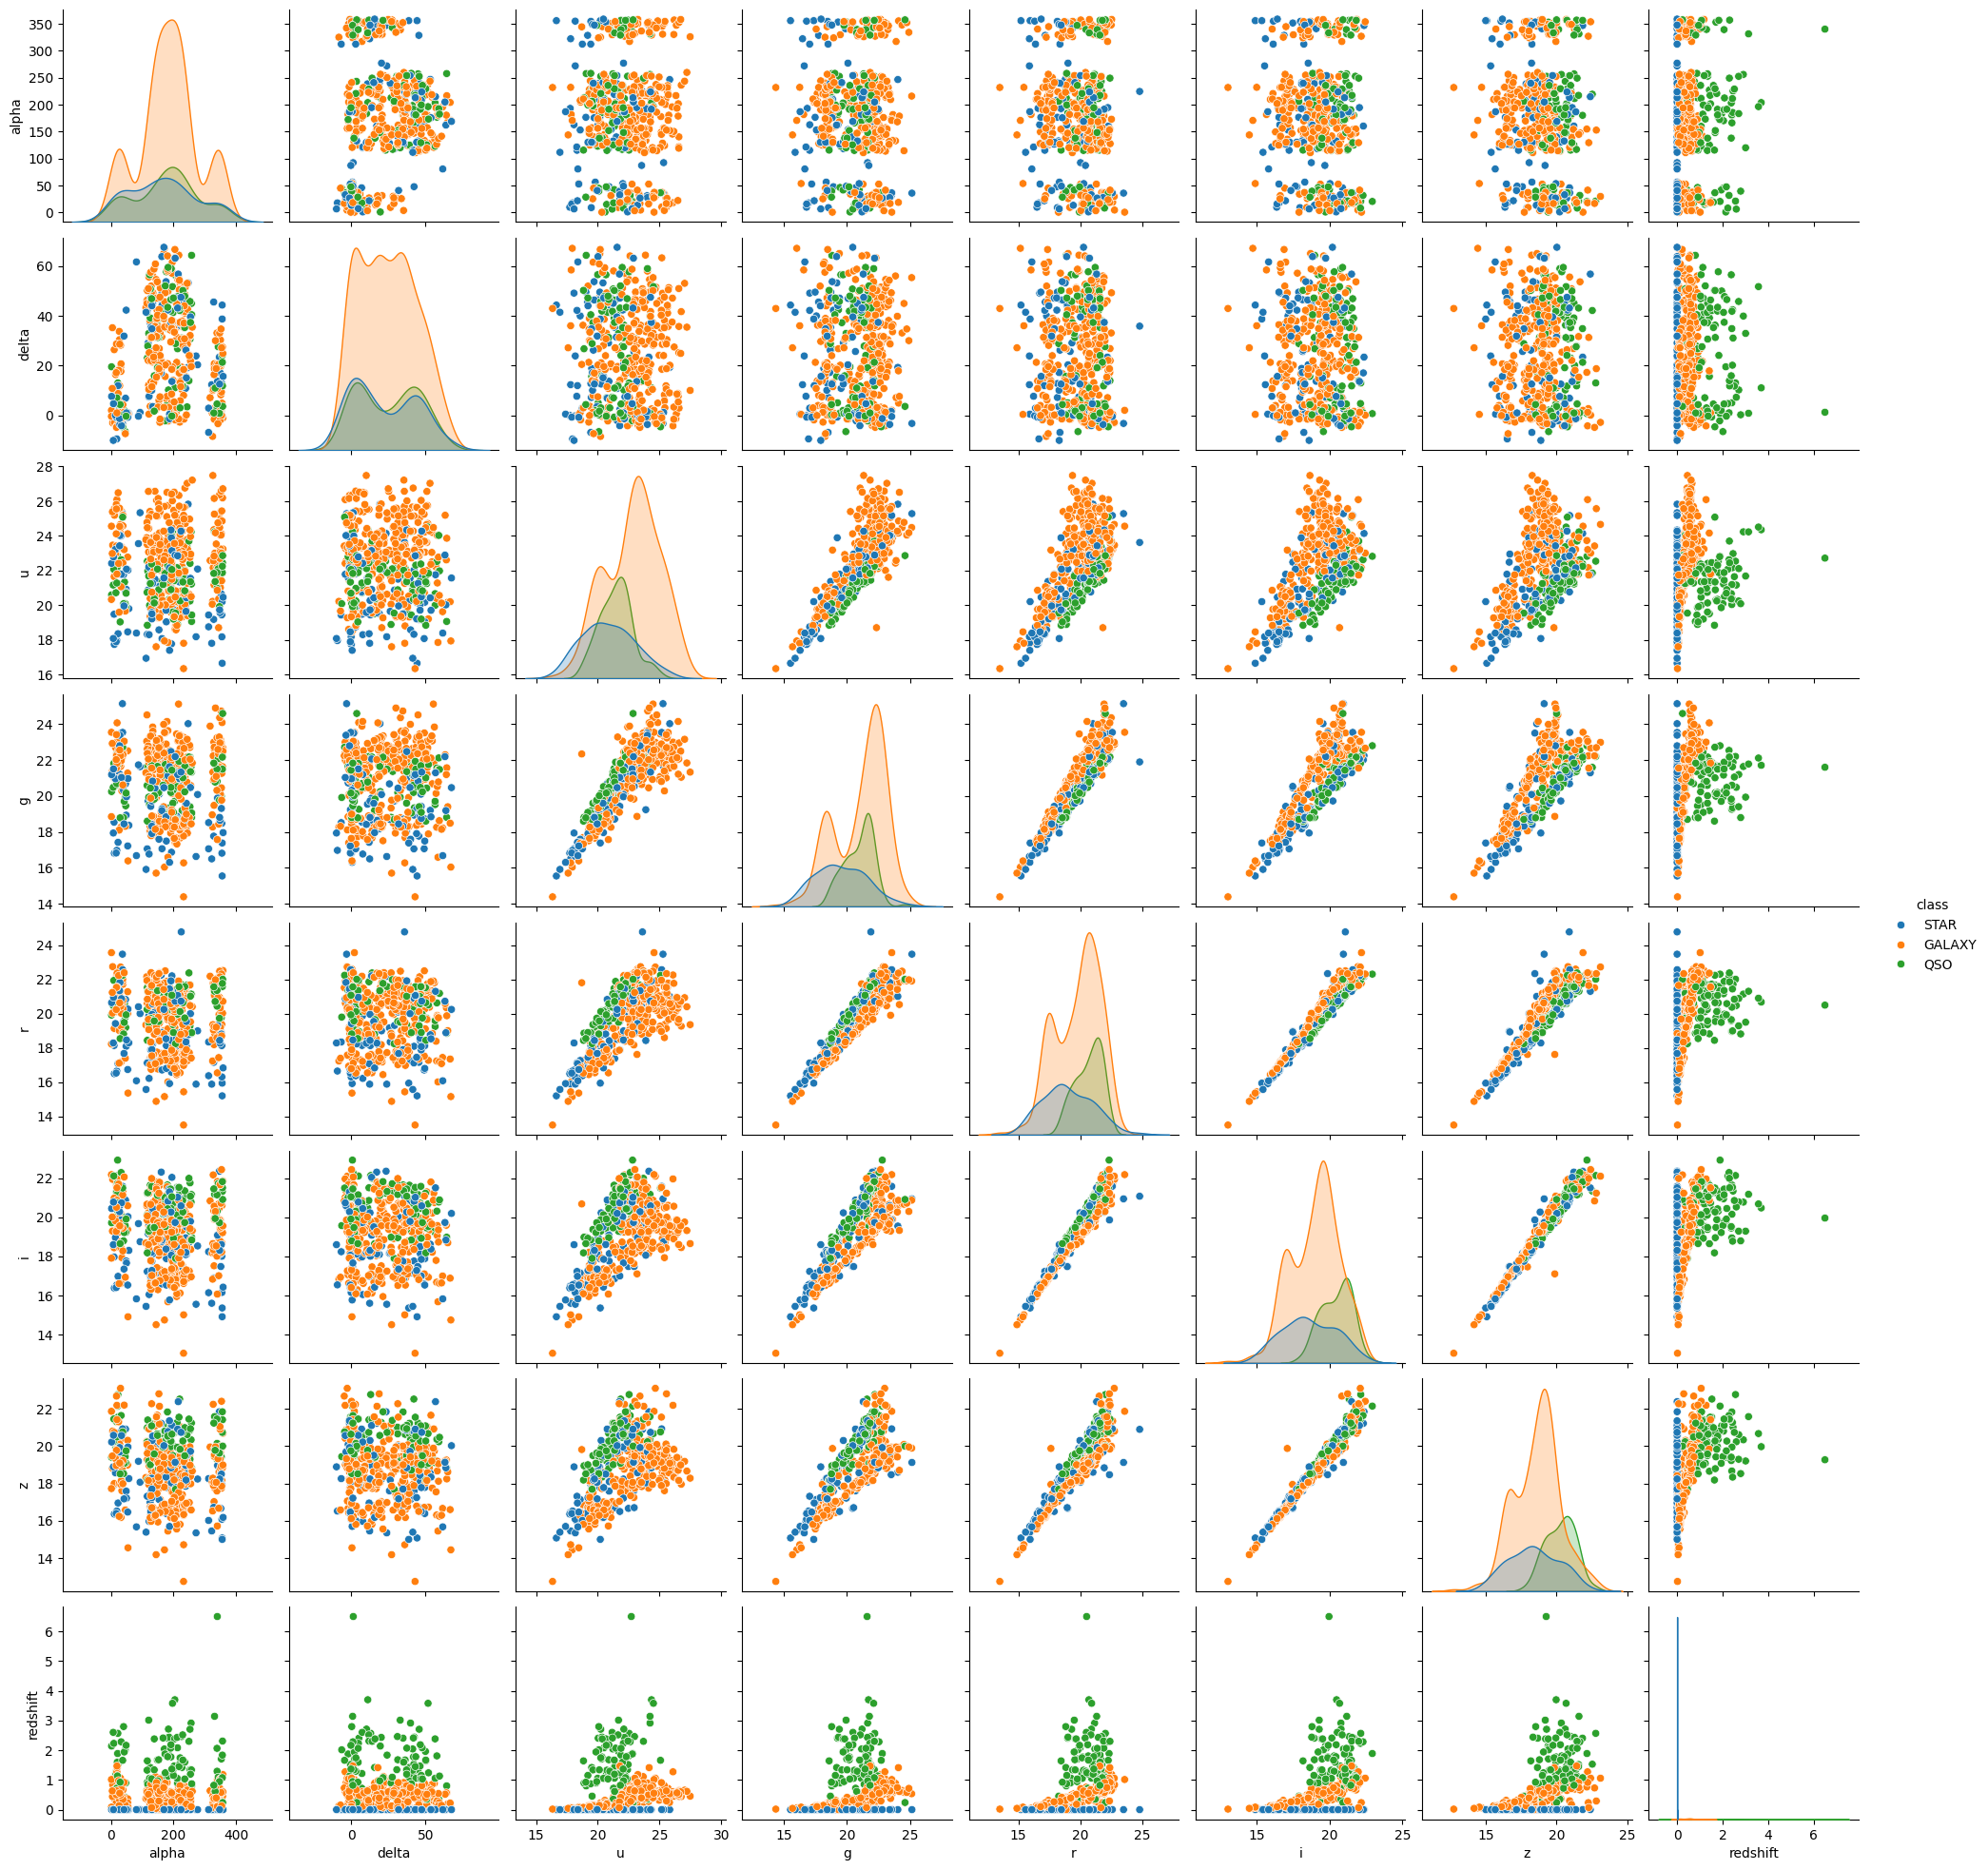

In [139]:
# Taking a portion of the dataframe for visualising the correlations (all 100k rows would take too long)
df_test = df.sample(n=100)
print(df_test.shape)

# Pairplot can give an idea about the important variables for predicting the class
# Especially useful are features that make it easy to separate clusters of the classes
sns.pairplot(data=df_test, hue="class")

In [140]:
# Getting a detailed overview of the kinds of values for the three classes
for star_type in df["class"].unique():
    df_star = df.loc[df['class'] == star_type]
    print(f"\nInformation about star class {star_type}:\n")
    print(df_star.describe())
    print("-----------------------------------------------------------------")

# Sampling 3000 rows to use for the model training
df = df.sample(n=3000)

df.columns


Information about star class GALAXY:

         alpha    delta        u        g        r        i        z  redshift
count 59445.00 59445.00 59445.00 59445.00 59445.00 59445.00 59445.00  59445.00
mean    177.95    23.51    22.59    20.91    19.59    18.85    18.45      0.42
std      94.40    19.32     2.26     2.11     1.87     1.69     1.66      0.26
min       0.01   -12.36    13.90    12.68    11.75    11.30    10.90     -0.01
25%     131.51     5.17    20.79    18.91    17.82    17.38    17.10      0.16
50%     181.32    22.30    22.84    21.58    20.10    19.22    18.77      0.46
75%     231.33    37.97    24.21    22.45    20.97    19.95    19.47      0.59
max     359.99    77.62    29.33    31.60    29.57    30.16    29.38      2.00
-----------------------------------------------------------------

Information about star class QSO:

         alpha    delta        u        g        r        i        z  redshift
count 18961.00 18961.00 18961.00 18961.00 18961.00 18961.00 18961.00 

Index(['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'class', 'redshift'], dtype='object')

In [141]:
# Drop the target variable to define the input features for the training
X = df.drop("class", axis=1)

# Leave the target variable for y
y = df['class']

# converting the class labels to be usable for training
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [142]:
# Looking at the remaining features to see if there are any especially important or unimportant ones

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

# Redshift clearly is the main feature here, as expected the model performance tanks when dropping that column
# But the other features do still have a noticeable effect, so they stay too

,Features,Score
7,redshift,2859.58
1,delta,252.83
0,alpha,84.59
6,z,82.23
5,i,64.40
2,u,54.05
4,r,41.97
3,g,41.09


In [143]:
# Train/test split 80:20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [144]:
# Creating list of the categories
categories = list(np.unique(df['class']))

In [145]:
# Basic neural network for classification
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", input_shape=(len(X.columns),)),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# Model compilation and some info about the model
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 16)                144       
                                                                 
 dense_25 (Dense)            (None, 32)                544       
                                                                 
 dense_26 (Dense)            (None, 8)                 264       
                                                                 
 dense_27 (Dense)            (None, 3)                 27        
                                                                 
Total params: 1011 (3.95 KB)
Trainable params: 995 (3.89 KB)
Non-trainable params: 16 (64.00 Byte)
_____________________

In [146]:
# Fitting the model
model.fit(x=X_train, y=y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200


75/75 [==============================] - 1s 4ms/step - loss: 8.2006 - accuracy: 0.6275 - val_loss: 7.3676 - val_accuracy: 0.5733
Epoch 2/200
75/75 [==============================] - 0s 2ms/step - loss: 5.0427 - accuracy: 0.6879 - val_loss: 4.0406 - val_accuracy: 0.5833
Epoch 3/200
75/75 [==============================] - 0s 2ms/step - loss: 2.8303 - accuracy: 0.7275 - val_loss: 2.0423 - val_accuracy: 0.6967
Epoch 4/200
75/75 [==============================] - 0s 2ms/step - loss: 1.4427 - accuracy: 0.7367 - val_loss: 1.0413 - val_accuracy: 0.7233
Epoch 5/200
75/75 [==============================] - 0s 2ms/step - loss: 0.8410 - accuracy: 0.7367 - val_loss: 0.7764 - val_accuracy: 0.7167
Epoch 6/200
75/75 [==============================] - 0s 3ms/step - loss: 0.7364 - accuracy: 0.7387 - val_loss: 0.7376 - val_accuracy: 0.7200
Epoch 7/200
75/75 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.7437 - val_loss: 0.7153 - val_accuracy: 0.7200
Epoch 8/200
75/75 [======

<Axes: >

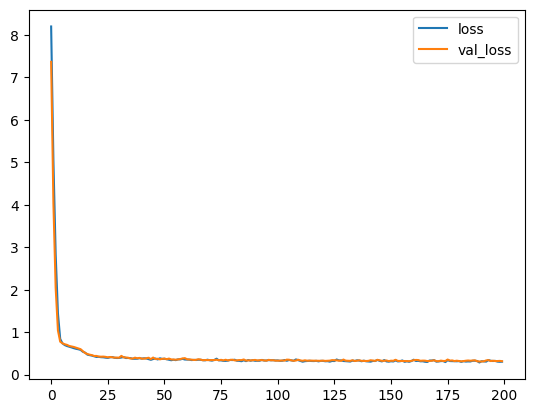

In [147]:
# Plotting the progression of loss and validation loss throughout the training
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

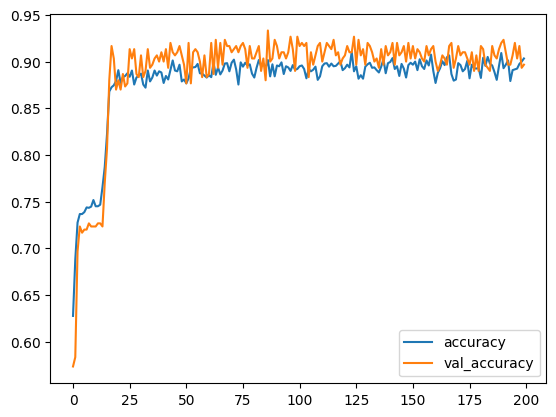

In [148]:
# Same thing for accuracy and validation accuracy
loss_df[['accuracy', 'val_accuracy']].plot()

In [149]:
# Comparing the final model loss/accuracy/evaluation values
# Matching values indicate a good result
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.27251365780830383, 0.9133333563804626]

Train data evaluation:
[0.25282296538352966, 0.9241666793823242]


In [150]:
# get predictions and convert with argmax() to get categories 
# instead of just the probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

10/10 [==============================] - 0s 1ms/step


<Axes: >

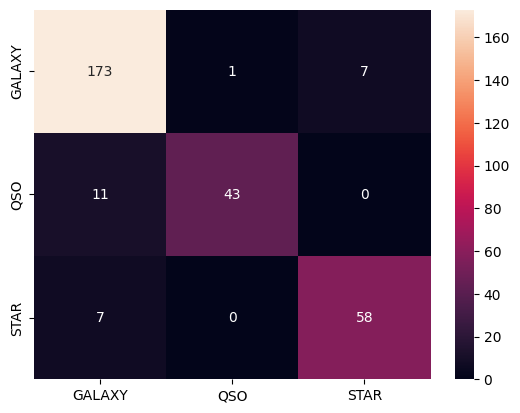

In [151]:
# Original heatmap without label names
# sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

# Using category names is more convenient
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [152]:
# Classification report based on predictions and real values
print(classification_report(y_test, test_predictions, target_names=categories))

# Overall accuracy score in a nicer format
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

      GALAXY       0.91      0.96      0.93       181
         QSO       0.98      0.80      0.88        54
        STAR       0.89      0.89      0.89        65

    accuracy                           0.91       300
   macro avg       0.93      0.88      0.90       300
weighted avg       0.92      0.91      0.91       300


Model overall accuracy: 91.33%


In [153]:
# Computing the ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

94/94 [==============================] - 0s 1ms/step


0.9801647283082576

I'm a bit disappointed that it again works quite well from the start, even without any specific optimizations, 

but there is still quite a bit of variation depending on the training run.

I will try to see what I can do about making a better model in a seperate file: ann_classification_improved.ipynb

In [154]:
# Making a new test prediction

test_row = {
    'alpha': 140, 
    'delta': 35, 
    'u': 25, 
    'g': 23, 
    'r': 20, 
    'i': 20, 
    'z': 19,
    'redshift': 4
}

# convert to pandas-format
tester_row = pd.DataFrame([test_row])
result = model.predict(tester_row)[0]
print(result.round(3))

result_index = np.argmax(result)
print(result_index)

# print the actual name with this index
result_text = categories[result_index]

# print the result
print(f"Predicted star class: {result_text}")

1/1 [==============================] - 0s 72ms/step
[0.119 0.881 0.   ]
1
Predicted star class: QSO
